In [1]:
#For timeseries analysis and dataframes
import pandas as pd
import datetime
#For Plots
import matplotlib.pyplot as plt
#Create Spark context
from pyspark.sql import SparkSession
#Importing Spark datatypes and SQL functions in order to create schema for tables
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark = SparkSession.builder.appName('SFBikeShareProd').getOrCreate()

### Importing data by specifying a schema
Below, we are importing the different tables along with their schemas. 
The tables imported for our initial analysis are"-

1. trip
2. station

When I imported the schema by specifying the timestamp fields in the initial load itself, I realised that the date fields were differently formatted for different time periods. The actual data begins from 2013-8-29 but when I imported the incorrect data, I get the following. The dataframe saves the dates starting from 3013-01-29. Also, it doesnt read the different date format which is why I thought that the dataset includes only one month data set from each year. 

In [2]:
##Importing dataset without fixing the date fields
##Importing CSV file directly using pyspark by specifying schema
trip_schema_corrected = StructType ([StructField ("id" , IntegerType(), True), StructField("duration", FloatType(), True),StructField("start_date", TimestampType(),True), StructField("start_station_name", StringType(), True), StructField("start_station_id", IntegerType(), True), StructField("end_date", TimestampType(),True), StructField("end_station_name", StringType(), True)\
									   , StructField("end_station_id", IntegerType(), True), StructField("bike_id", IntegerType(), True), StructField("subscription_type", StringType(), True), StructField("zip_code", StringType(), True)])
df_trip_2 = spark.read.load('D:/Data Sets/SF Bike Sharing Data/sf-bay-area-bike-share/trip.csv', format='csv', header='true',timestampFormat='mm/dd/yyyy hh:mm', schema=trip_schema_corrected)
df_trip_2.createOrReplaceTempView('trip_2')
df_trip_2.dtypes
df_trip_2.head(5)

[Row(id=4576, duration=63.0, start_date=datetime.datetime(2013, 1, 29, 14, 13), start_station_name='South Van Ness at Market', start_station_id=66, end_date=datetime.datetime(2013, 1, 29, 14, 14), end_station_name='South Van Ness at Market', end_station_id=66, bike_id=520, subscription_type='Subscriber', zip_code='94127'),
 Row(id=4607, duration=70.0, start_date=datetime.datetime(2013, 1, 29, 14, 42), start_station_name='San Jose City Hall', start_station_id=10, end_date=datetime.datetime(2013, 1, 29, 14, 43), end_station_name='San Jose City Hall', end_station_id=10, bike_id=661, subscription_type='Subscriber', zip_code='95138'),
 Row(id=4130, duration=71.0, start_date=datetime.datetime(2013, 1, 29, 10, 16), start_station_name='Mountain View City Hall', start_station_id=27, end_date=datetime.datetime(2013, 1, 29, 10, 17), end_station_name='Mountain View City Hall', end_station_id=27, bike_id=48, subscription_type='Subscriber', zip_code='97214'),
 Row(id=4251, duration=77.0, start_date=

In [3]:
##Importing dataset with the corrected date fields
trip_schema_2 = StructType ([StructField ("id" , IntegerType(), True), StructField("duration", FloatType(), True),StructField("start_date", StringType(),True), StructField("start_station_name", StringType(), True), StructField("start_station_id", IntegerType(), True), StructField("end_date", StringType(),True), StructField("end_station_name", StringType(), True)\
									   , StructField("end_station_id", IntegerType(), True), StructField("bike_id", IntegerType(), True), StructField("subscription_type", StringType(), True), StructField("zip_code", StringType(), True)])
df_trip_3 = spark.read.load('D:/Data Sets/SF Bike Sharing Data/sf-bay-area-bike-share/trip.csv', format='csv', header='true', schema=trip_schema_2)
df_trip_3.createOrReplaceTempView('trip_3')
##Correcting the date fields - replacing the '-' with '/' for consistency across all date fields
df_trip_3.withColumn('start_date', regexp_replace('start_date','-','/') )
df_trip_3.withColumn('end_date', regexp_replace('end_date','-','/') )
#Converting the start_date and end_date to timestamp. This SQL function doesnt work as seen below in the datatypes
df_trip_3.withColumn('start_date', to_timestamp('start_date', 'mm/dd/yyyy hh:mm'))
df_trip_3.withColumn('end_date', to_timestamp('end_date', 'mm/dd/yyyy hh:mm'))
df_trip_3.dtypes
#df_trip_3.head(50)

[('id', 'int'),
 ('duration', 'float'),
 ('start_date', 'string'),
 ('start_station_name', 'string'),
 ('start_station_id', 'int'),
 ('end_date', 'string'),
 ('end_station_name', 'string'),
 ('end_station_id', 'int'),
 ('bike_id', 'int'),
 ('subscription_type', 'string'),
 ('zip_code', 'string')]

In [4]:
##Importing station data
#reading station data
station_schema =StructType([StructField("id", IntegerType(), True), StructField("name", StringType(), True), StructField("lat", FloatType(),True), StructField("long", FloatType(), True), StructField("dock_count", IntegerType(),True),  StructField("city",StringType(), True), StructField("installation_date",DateType(), True)])
df_station = spark.read.load('D:/Data Sets/SF Bike Sharing Data/sf-bay-area-bike-share/station.csv', format='csv', header='true', schema=station_schema)
df_station.createOrReplaceTempView('station')

For initial analysis, I am considering the station data of only one station. Station with id = 70. 
This is bacuase the vilume of data is large. Selecting only one station data for analysis initially. Will go in more depth as soon as I identify analysis goals.

In [5]:
#Combining trip and station data. We are getting the number of cycles available for the station and latitude and longitude information of other stations
station_70_detailed = spark.sql('select a.id, (a.duration/60) as trip_duration, a.start_station_name, a.start_date, a.start_station_id, b.lat, b.long, a.end_date, a.end_station_id, a.bike_id, a.subscription_type, a.zip_code, b.city, b.dock_count from trip_3 a LEFT OUTER JOIN station b ON a.start_station_id = b.id WHERE a.start_station_id = 70')
station_70_detailed.collect()
station_70_detailed.createOrReplaceTempView('iter_1')

station_70_detailed_2 = spark.sql('select a.id, a.trip_duration,a.start_station_name, a.start_date, a.start_station_id, a.lat, a.long, a.end_date, a.end_station_id, b.lat as lat_end, b.long as long_end,  a.bike_id, a.subscription_type, a.zip_code, a.city, a.dock_count from iter_1 a LEFT OUTER JOIN station b ON a.end_station_id = b.id')
station_70_detailed_2.show(5)

+----+------------------+--------------------+---------------+----------------+---------+----------+---------------+--------------+---------+----------+-------+-----------------+--------+-------------+----------+
|  id|     trip_duration|  start_station_name|     start_date|start_station_id|      lat|      long|       end_date|end_station_id|  lat_end|  long_end|bike_id|subscription_type|zip_code|         city|dock_count|
+----+------------------+--------------------+---------------+----------------+---------+----------+---------------+--------------+---------+----------+-------+-----------------+--------+-------------+----------+
|4673|3.9833333333333334|San Francisco Cal...|8/29/2013 15:48|              70|37.776615|-122.39526|8/29/2013 15:52|            65|37.771057|-122.40272|    568|       Subscriber|   94110|San Francisco|        19|
|4177| 4.633333333333334|San Francisco Cal...|8/29/2013 11:03|              70|37.776615|-122.39526|8/29/2013 11:08|            64| 37.78226|-122.39

### Initial Analysis of the data

1. Trips from each station
2. subscriber makeup
3. 

In [6]:
#Number of trips from each station
trip_count=spark.sql('select start_station_id,count(*) as row_count from trip_3 group by start_station_id order by count(*) desc')
trip_count.show(20)
pd_trip_count = trip_count.toPandas()

+----------------+---------+
|start_station_id|row_count|
+----------------+---------+
|              70|    49092|
|              69|    33742|
|              50|    32934|
|              60|    27713|
|              55|    26089|
|              61|    25837|
|              74|    24838|
|              77|    24172|
|              65|    23724|
|              67|    20272|
|              76|    20165|
|              64|    18496|
|              39|    18378|
|              73|    16306|
|              62|    15940|
|              56|    15709|
|              54|    14811|
|              72|    14102|
|              51|    14054|
|              57|    13526|
+----------------+---------+
only showing top 20 rows



In [7]:
#getting trip counts by station
pd_trip_count.count()
pd_trip_count_max = pd_trip_count.loc[pd_trip_count['row_count']>5000]
pd_trip_count_min = pd_trip_count.loc[pd_trip_count['row_count']<5000]

<function matplotlib.pyplot.show(*args, **kw)>

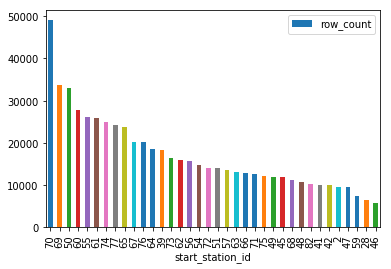

<Figure size 2520x2520 with 0 Axes>

In [8]:
#Number of trips from the top stations
pd_trip_count_max.plot.bar(grid=False, x='start_station_id', y='row_count')
plt.figure(figsize=(35,35))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

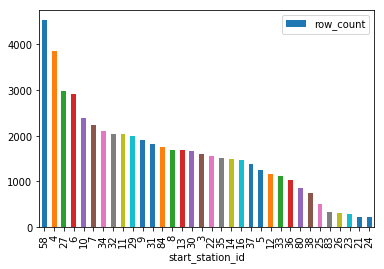

<Figure size 2520x2520 with 0 Axes>

In [9]:
#Number of trips from the bottom stations
pd_trip_count_min.plot.bar(grid=False, x='start_station_id', y='row_count')
plt.figure(figsize=(35,35))
plt.show

In [10]:
#Customer makeup - Subscriber vs One-time customer
subscriber_type_trips=spark.sql('select subscription_type,count(*) as trip_count from trip_3 group by subscription_type order by count(*) desc')
subscriber_type_trips.show()
pd_subscr_type_trips = subscriber_type_trips.toPandas()

+-----------------+----------+
|subscription_type|trip_count|
+-----------------+----------+
|       Subscriber|    566746|
|         Customer|    103213|
+-----------------+----------+



                   trip_count
subscription_type            
Subscriber             566746
Customer               103213


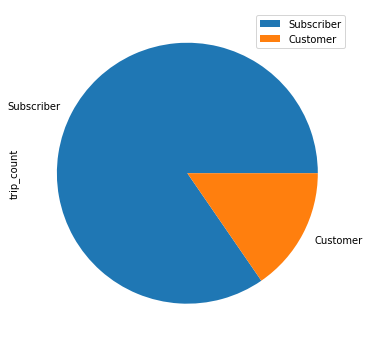

In [11]:
#Customer makeup - Subscriber vs One-time customer
pd_subscriber_type_trips = pd_subscr_type_trips.set_index(['subscription_type'])
print(pd_subscriber_type_trips)
pd_subscriber_type_trips.plot.pie(y='trip_count', figsize=(6,6))
plt.show()

### Time series analysis using pandas

In [12]:
##Experimental Time series - analyzing data from one station
pd_station_70 = station_70_detailed_2.toPandas()
pd_station_70['start_date'] = pd.to_datetime(pd_station_70['start_date'])
pd_station_70['end_date'] = pd.to_datetime(pd_station_70['end_date'])
#Setting start_date as index
pd_station_70.set_index('start_date', inplace=True)

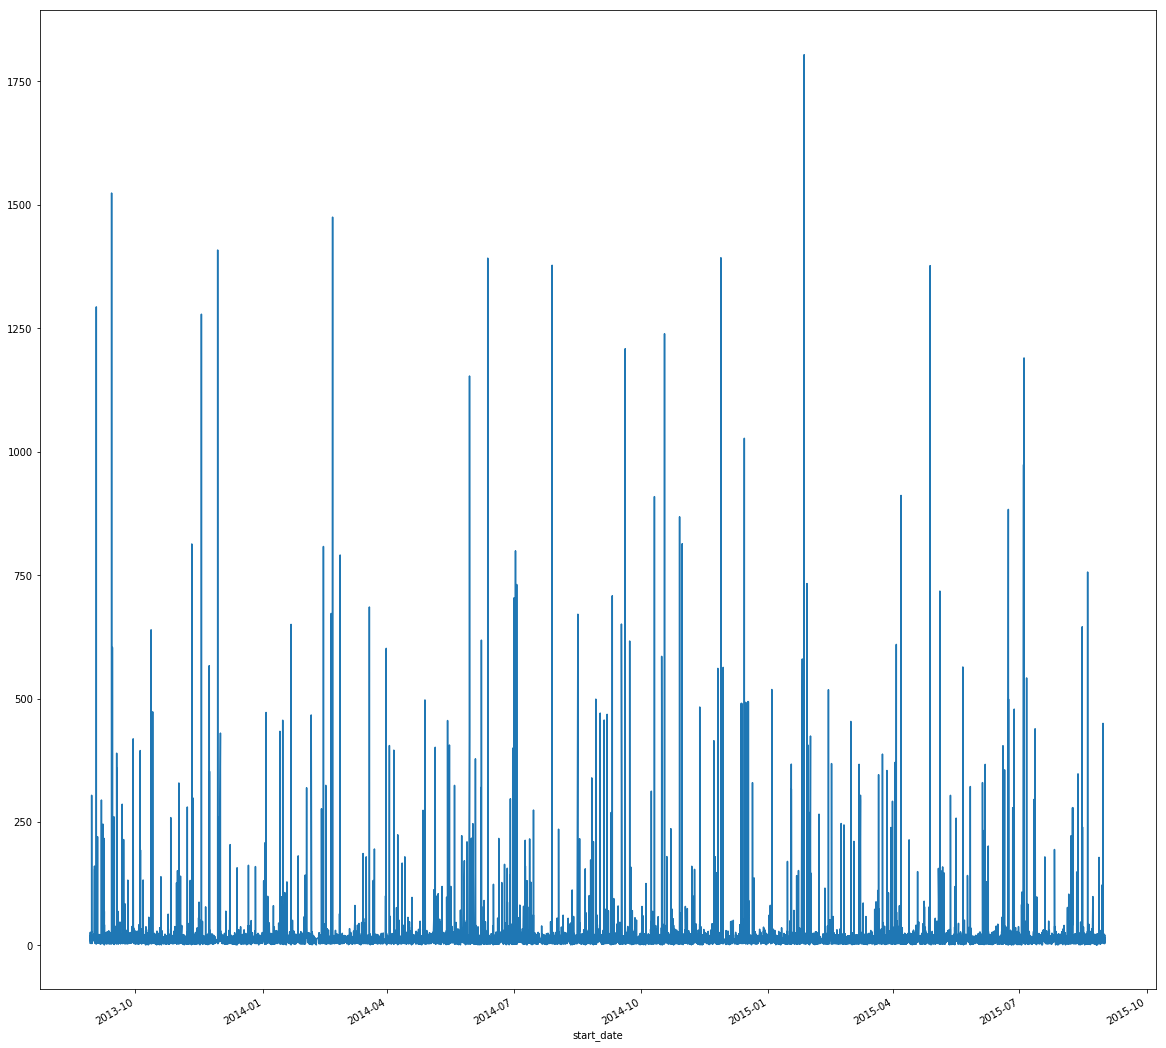

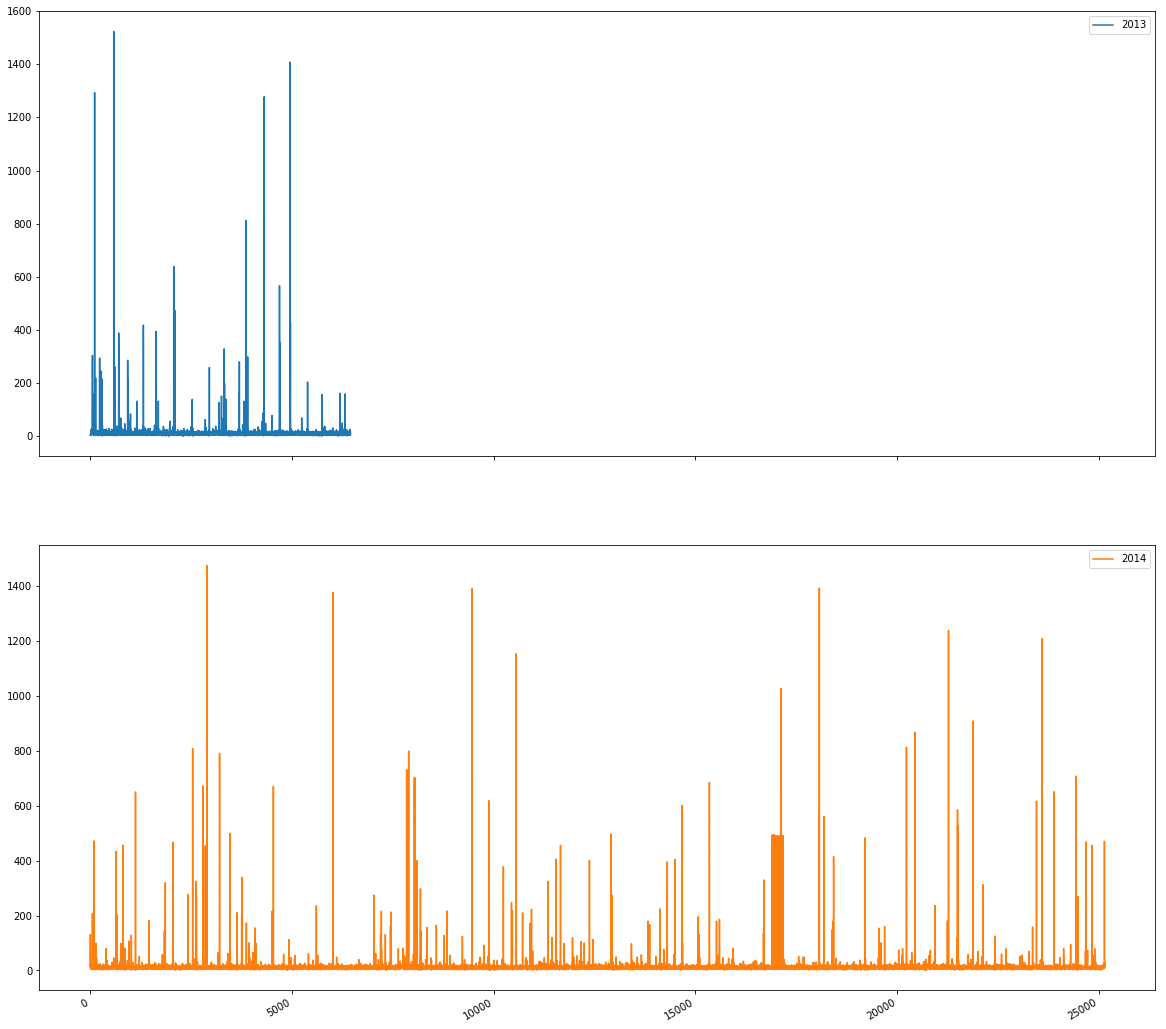

In [13]:

#Converting seconds to minutes
#pd_station_70['dur_min'] = round(pd_station_70['duration']/60,1)

#General time series on duration
pd_station_70.trip_duration.plot(figsize=(20,20))
plt.show()


#Duration by year
duration = pd.DataFrame()
for year in ['2013', '2014']:
    duration_per_year = pd_station_70.loc[year,['trip_duration']].reset_index(drop=True)
    duration_per_year.rename(columns={'trip_duration':year}, inplace=True)
    duration = pd.concat([duration,duration_per_year], axis=1)
    
#Plot time series of duration for each year
duration.plot(figsize=(20,20), subplots=True)
plt.show()

#### Calculating the distance between two points given latitude and longitude.

In [14]:
import geopy.distance

coords_1 = (37.776615, -122.39526)
coords_2 = (37.771057, -122.40272)

geopy.distance.vincenty(coords_1, coords_2).km

0.9013988601177375

In [15]:
def calcDistance(x):
    coords_1 = (x[0], x[1])
    coords_2 = (x[2], x[3])
    return geopy.distance.vincenty(coords_1, coords_2).km

In [16]:
pd_station_70['distance'] = pd_station_70[['lat', 'long', 'lat_end', 'long_end']].apply(calcDistance, axis=1)

In [17]:
pd_station_70['distance'].head(5)

start_date
2013-08-29 15:48:00    0.901009
2013-08-29 11:03:00    0.664954
2013-08-29 16:23:00    0.901009
2013-08-29 16:24:00    0.901009
2013-08-29 22:53:00    1.177382
Name: distance, dtype: float64

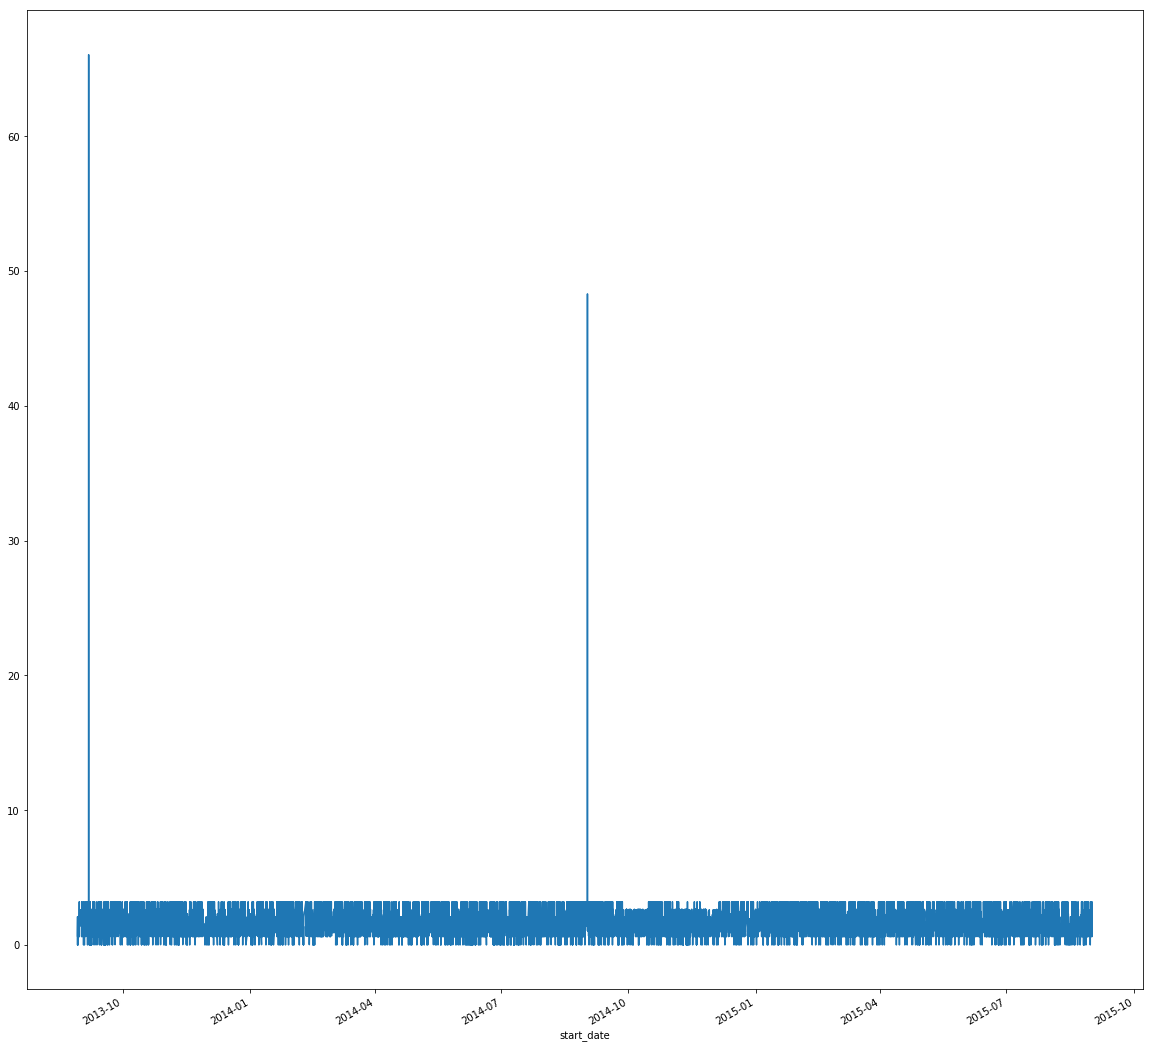

In [18]:
pd_station_70.distance.plot(figsize=(20,20))
plt.show()

### Number of trips by month

In [19]:
pd_station_70 = pd_station_70.groupby(by=[ pd_station_70.index.month, pd_station_70.index.year])

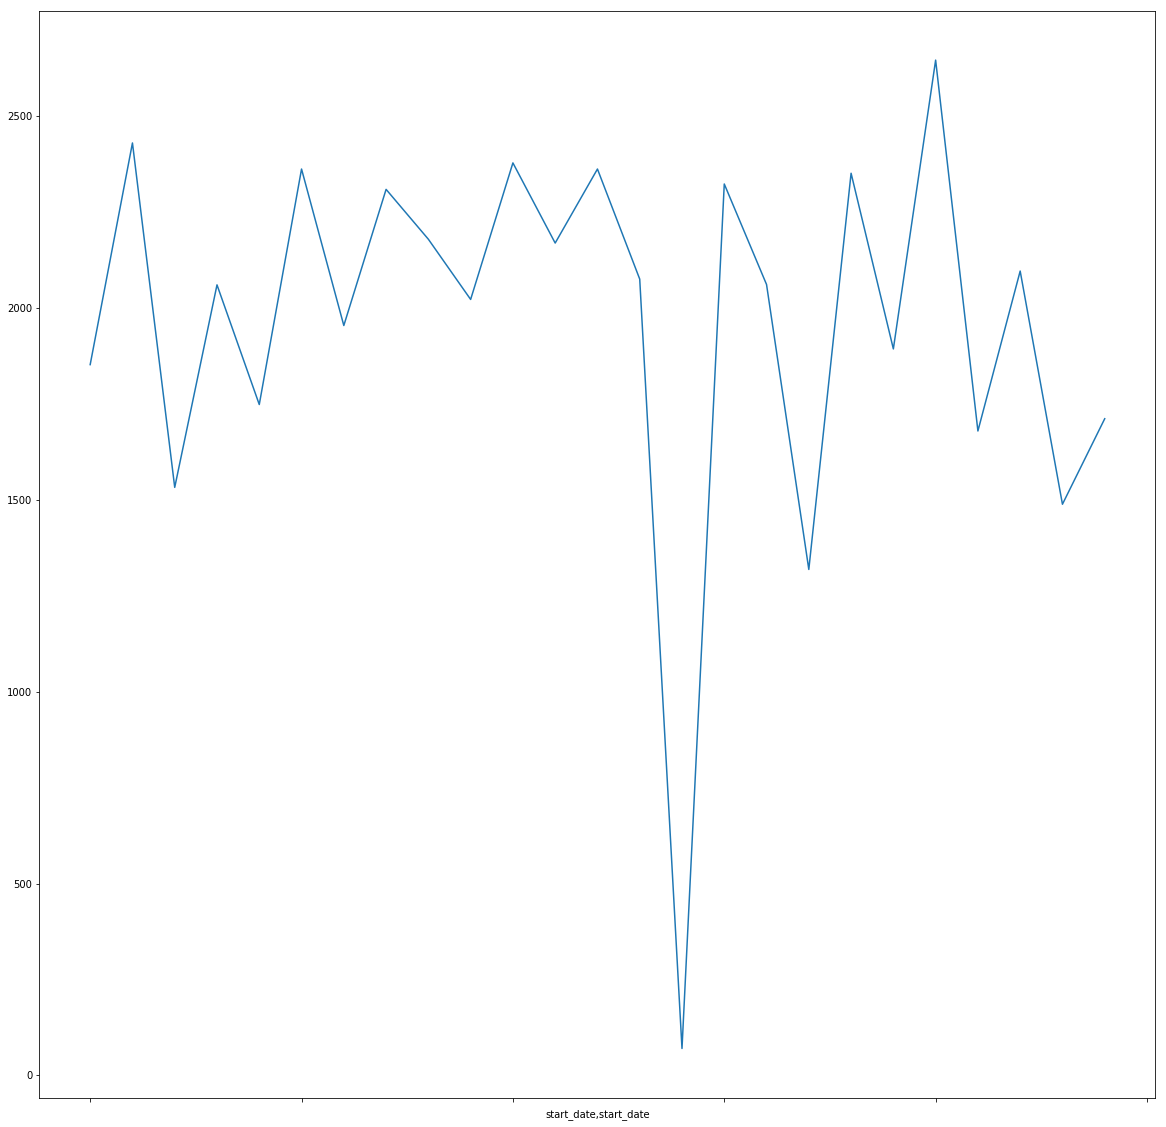

In [20]:
#This graph needs some fixing
pd_station_70.id.count().plot(figsize=(20,20))

In [27]:
pd_station_70['trip_count'] = 1
#pd_station_70 = pd_station_70['trip_count'].resample('m').sum()

TypeError: 'DataFrameGroupBy' object does not support item assignment

In [24]:
pd_station_70.head()
pd_station_70['2013-01-01']

KeyError: 'Column not found: 2013-01-01'

In [25]:
pd_station_70.plot(figsize=(20,20))
plt.show()

ValueError: view limit minimum -36891.78205336677 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000023D53598158> (for post_execute):


ValueError: view limit minimum -36891.78205336677 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36891.78205336677 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [28]:
station_70_all = spark.sql('select * from trip_3 where start_station_id = 70 OR end_station_id = 70')

In [29]:
station_70_all.createOrReplaceTempView('stat70_all')

In [30]:
station_70_all_details = spark.sql('select a.id, (a.duration/60) as trip_duration, a.start_station_name, a.start_date, a.start_station_id, b.lat, b.long, a.end_date, a.end_station_id, a.bike_id, a.subscription_type, a.zip_code, b.city, b.dock_count from stat70_all a LEFT OUTER JOIN station b ON a.start_station_id = b.id')
station_70_all_details.collect()
station_70_all_details.createOrReplaceTempView('iter_3')

station_70_all_details_final = spark.sql('select a.id, a.trip_duration,a.start_station_name, a.start_date, a.start_station_id, a.lat, a.long, a.end_date, a.end_station_id, b.lat as lat_end, b.long as long_end,  a.bike_id, a.subscription_type, a.zip_code, a.city, a.dock_count as start_stat_dock_count, b.dock_count as end_stat_dock_count from iter_3 a LEFT OUTER JOIN station b ON a.end_station_id = b.id')
station_70_all_details_final.show(5)

+----+------------------+--------------------+---------------+----------------+---------+----------+---------------+--------------+---------+----------+-------+-----------------+--------+-------------+---------------------+-------------------+
|  id|     trip_duration|  start_station_name|     start_date|start_station_id|      lat|      long|       end_date|end_station_id|  lat_end|  long_end|bike_id|subscription_type|zip_code|         city|start_stat_dock_count|end_stat_dock_count|
+----+------------------+--------------------+---------------+----------------+---------+----------+---------------+--------------+---------+----------+-------+-----------------+--------+-------------+---------------------+-------------------+
|4673|3.9833333333333334|San Francisco Cal...|8/29/2013 15:48|              70|37.776615|-122.39526|8/29/2013 15:52|            65|37.771057|-122.40272|    568|       Subscriber|   94110|San Francisco|                   19|                 15|
|5105| 4.083333333333333

In [31]:
pd_station_70_all = station_70_all_details_final.toPandas()

In [32]:
pd_station_70_all['start_date'] = pd.to_datetime(pd_station_70_all['start_date'])
pd_station_70_all['end_date'] = pd.to_datetime(pd_station_70_all['end_date'])
#setting start time as index for new dataframe
pd_station_70_all.set_index('start_date', inplace=True)

In [33]:
pd_station_70_all = pd_station_70_all.sort_index()

In [34]:
pd_station_70_all.head(20)

,id,trip_duration,start_station_name,start_station_id,lat,long,end_date,end_station_id,lat_end,long_end,bike_id,subscription_type,zip_code,city,start_stat_dock_count,end_stat_dock_count
start_date,,,,,,,,,,,,,,,,
2013-08-29 11:03:00,4177,4.633333,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:08:00,64,37.782261,-122.392738,371,Subscriber,94117,San Francisco,19,15
2013-08-29 11:17:00,4218,26.550000,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:43:00,66,37.774815,-122.418953,377,Subscriber,94114,San Francisco,19,19
2013-08-29 11:17:00,4217,25.583333,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:42:00,66,37.774815,-122.418953,370,Subscriber,94703,San Francisco,19,19
2013-08-29 11:18:00,4221,25.000000,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:43:00,66,37.774815,-122.418953,546,Subscriber,94123,San Francisco,19,19
2013-08-29 11:18:00,4219,19.166667,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:37:00,72,37.781040,-122.411751,597,Subscriber,97214,San Francisco,19,23
2013-08-29 11:26:00,4244,17.850000,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:44:00,58,37.778648,-122.418236,572,Subscriber,94122,San Francisco,19,19
2013-08-29 11:26:00,4243,12.000000,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:38:00,70,37.776615,-122.395264,538,Subscriber,94117,San Francisco,19,19
2013-08-29 11:32:00,4256,10.483333,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:43:00,54,37.787151,-122.388016,376,Subscriber,94105,San Francisco,19,15
2013-08-29 11:54:00,4282,9.533333,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 12:04:00,65,37.771057,-122.402718,538,Customer,37206,San Francisco,19,15


In [35]:
cycle_count = 19
cycle_availability = []

for x in pd_station_70_all['start_station_id']:
    if x == 70:
        cycle_availability.append(cycle_count-1)
        cycle_count = cycle_count-1
    elif x!=70:
        cycle_availability.append(cycle_count+1)
        cycle_count = cycle_count + 1

pd_station_70_all['cycles_available']= cycle_availability

        


In [55]:
# Functions to Calculating the outgoing and incoming bikes
def outgoing(row):
    if row['start_station_id'] == 70:
        return 1
    if row['end_station_id'] == 70:
        return 0

def incoming(row):
     if row['start_station_id'] == 70:
        return 0
     if row['end_station_id'] == 70:
        return 1
    


In [58]:
#Adding outgoing and incoming columns to the data set
pd_station_70_all['outgoing'] = pd_station_70_all.apply(lambda row: outgoing(row), axis=1)
pd_station_70_all['incoming'] = pd_station_70_all.apply(lambda row: incoming(row), axis=1)

In [59]:
pd_station_70_all.head(50)

,id,trip_duration,start_station_name,start_station_id,lat,long,end_date,end_station_id,lat_end,long_end,bike_id,subscription_type,zip_code,city,start_stat_dock_count,end_stat_dock_count,cycles_available,outgoing,incoming
start_date,,,,,,,,,,,,,,,,,,,
2013-08-29 11:03:00,4177,4.633333,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:08:00,64,37.782261,-122.392738,371,Subscriber,94117,San Francisco,19,15,18,1,0
2013-08-29 11:17:00,4218,26.550000,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:43:00,66,37.774815,-122.418953,377,Subscriber,94114,San Francisco,19,19,17,1,0
2013-08-29 11:17:00,4217,25.583333,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:42:00,66,37.774815,-122.418953,370,Subscriber,94703,San Francisco,19,19,16,1,0
2013-08-29 11:18:00,4221,25.000000,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:43:00,66,37.774815,-122.418953,546,Subscriber,94123,San Francisco,19,19,15,1,0
2013-08-29 11:18:00,4219,19.166667,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:37:00,72,37.781040,-122.411751,597,Subscriber,97214,San Francisco,19,23,14,1,0
2013-08-29 11:26:00,4244,17.850000,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:44:00,58,37.778648,-122.418236,572,Subscriber,94122,San Francisco,19,19,13,1,0
2013-08-29 11:26:00,4243,12.000000,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:38:00,70,37.776615,-122.395264,538,Subscriber,94117,San Francisco,19,19,12,1,0
2013-08-29 11:32:00,4256,10.483333,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 11:43:00,54,37.787151,-122.388016,376,Subscriber,94105,San Francisco,19,15,11,1,0
2013-08-29 11:54:00,4282,9.533333,San Francisco Caltrain (Townsend at 4th),70,37.776615,-122.395264,2013-08-29 12:04:00,65,37.771057,-122.402718,538,Customer,37206,San Francisco,19,15,10,1,0


In [70]:
##resampling data hourly
outgoing_per_hour = pd_station_70_all['outgoing'].resample('30T', label='left').sum()
outgoing_per_hour.head()

start_date
2013-08-29 11:00:00    7
2013-08-29 11:30:00    2
2013-08-29 12:00:00    0
2013-08-29 12:30:00    0
2013-08-29 13:00:00    0
Freq: 30T, Name: outgoing, dtype: int64

In [71]:
incoming_per_hour = pd_station_70_all['incoming'].resample('30T', label='left').sum()
incoming_per_hour.head(5)

start_date
2013-08-29 11:00:00    0
2013-08-29 11:30:00    0
2013-08-29 12:00:00    1
2013-08-29 12:30:00    0
2013-08-29 13:00:00    2
Freq: 30T, Name: incoming, dtype: int64

In [37]:
dockstatus_df = spark.read.load('D:\Data Sets\SF Bike Sharing Data\sf-bay-area-bike-share/status.csv', format='csv', header='true',timestampFormat='mm/dd/yyyy hh:mm')
dockstatus_df.createOrReplaceTempView('status')


In [38]:
dock_status_70 = spark.sql( 'select * from status where station_id = 70')
p_df_dock_status_70 = dock_status_70.toPandas()
p_df_dock_status_70['time'] = pd.to_datetime(p_df_dock_status_70['time'])

In [39]:
p_df_dock_status_70.set_index('time', inplace=True)

In [66]:
p_df_dock_status_70.sort_index()
p_df_dock_status_70.head(5)

,station_id,bikes_available,docks_available
time,,,
2013-08-29 12:06:01,70,0,19
2013-08-29 12:07:01,70,0,19
2013-08-29 12:08:01,70,0,19
2013-08-29 12:09:01,70,0,19
2013-08-29 12:10:01,70,0,19


In [74]:
#Resampling Dock Status for every 30 mins
p_df_new_dockStatus = p_df_dock_status_70.resample('30T', label='left').last()

In [75]:
p_df_new_dockStatus.head(5)

,station_id,bikes_available,docks_available
time,,,
2013-08-29 12:00:00,70,2,17
2013-08-29 12:30:00,70,2,17
2013-08-29 13:00:00,70,3,16
2013-08-29 13:30:00,70,5,14
2013-08-29 14:00:00,70,5,14


In [76]:
data_frames = [p_df_new_dockStatus,outgoing_per_hour, incoming_per_hour]
bike_availability_df = pd.concat(data_frames, join = 'inner', axis=1, join_axes=[p_df_new_dockStatus.index])

In [89]:
def threshold(row):
    if row['bikes_available'] < 4:
        return 1
    if row['bikes_available'] >=0:
        return 0

In [93]:
bike_availability_df['bikes_available'] = pd.to_numeric(bike_availability_df['bikes_available'])
bike_availability_df['replenish'] = bike_availability_df.apply(lambda row: threshold(row), axis=1)

In [94]:
bike_availability_df['outgoing_24H'] = bike_availability_df['outgoing'].rolling(window=48).mean()
bike_availability_df['incoming_24H'] = bike_availability_df['incoming'].rolling(window=48).mean()
bike_availability_df['outgoing-incoming-ratio'] = bike_availability_df['outgoing_24H']/bike_availability_df['incoming_24H']

In [96]:
bike_availability_df.tail(50)

,station_id,bikes_available,docks_available,outgoing,incoming,outgoing_24H,incoming_24H,outgoing-incoming-ratio,replenish
time,,,,,,,,,
2015-08-30 23:00:00,70,13.0,6,0.0,0.0,0.208333,0.166667,1.250000,0.0
2015-08-30 23:30:00,70,13.0,6,0.0,0.0,0.208333,0.166667,1.250000,0.0
2015-08-31 00:00:00,70,13.0,6,0.0,0.0,0.208333,0.166667,1.250000,0.0
2015-08-31 00:30:00,70,13.0,6,0.0,0.0,0.208333,0.166667,1.250000,0.0
2015-08-31 01:00:00,70,13.0,6,0.0,0.0,0.208333,0.166667,1.250000,0.0
2015-08-31 01:30:00,70,13.0,6,0.0,0.0,0.208333,0.166667,1.250000,0.0
2015-08-31 02:00:00,70,13.0,6,0.0,0.0,0.208333,0.166667,1.250000,0.0
2015-08-31 02:30:00,70,13.0,6,0.0,0.0,0.208333,0.166667,1.250000,0.0
2015-08-31 03:00:00,70,13.0,6,0.0,0.0,0.208333,0.166667,1.250000,0.0
